## Imports, Constants, and Symbols

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

In [2]:
eps0 = 800/130
beta = 1/6*(np.sqrt(2)+np.log(1+np.sqrt(2)))
zeta = 2*beta

# Calculate non-dimensional Q (=M/R) in terms of dimensional parameters
E = 8000 # per <r>^2
mean_distance = 1
mu = 10 # per day
nu = 1 # per day
Q = mu/(nu*E*mean_distance**2) # = M/R

A = mean_distance*2 # Upper constant for uniform Distr.
M = 1000
ell_min = 0.1
ell_max = 2 # For uniform Distr. it does not make sense to go further, otherwise system becomes unimodal
ell_list = np.linspace(ell_min,ell_max,M)

In [3]:
# For treating Q as a dependend parameter
def Q_func(mu):
    return mu/(nu*E*mean_distance**2)

## Define probability distributions

In [4]:
def inverseGammaDistUnnormalized(x, k=3.1):
    if (x==0):
        return 0
    else:
        return (x**(-k))*np.exp(-(k-2)/x)


def uniformDist(x):
    if (x>A):
        return 0
    else:
        return 1/A
    
normalization_uniform, _ = scipy.integrate.quad(uniformDist,0,np.infty)
assert np.isclose(1, normalization_uniform), "Should already be normalized"
normalization_inverse_gamma, _ = scipy.integrate.quad(inverseGammaDistUnnormalized,0,np.infty)

print("Normalization factor for Uniform distribution: ", normalization_uniform)
print("Normalization factor for InverseGamma distribution: ", normalization_inverse_gamma)

def inverseGammaDist(x):
    return inverseGammaDistUnnormalized(x)/normalization_inverse_gamma

Normalization factor for Uniform distribution:  0.9999999999999855
Normalization factor for InverseGamma distribution:  0.8566604564575231


## Choose Probability Distribution and plot it

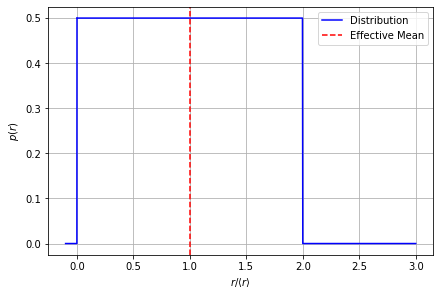

In [5]:
%matplotlib inline

# Either "uniformDist" or "inverseGammaDist"
probabilityDist = uniformDist

# Function for r*p(r)
rpr = lambda r : r*probabilityDist(r)

fig, ax = plt.subplots(constrained_layout=True)

x = np.linspace(0.001,3*mean_distance,1000)
probabilities = np.vectorize(probabilityDist)(x)
ax.plot(x, probabilities, label='Distribution', c='b')
ax.plot([-0.1,0,x[0]], [0,0,probabilities[0]], c='b')
ax.axvline(mean_distance, ls='--', c='r', label='Effective Mean')
ax.grid()
ax.set_xlabel(r"$r/\langle r\rangle$")
ax.set_ylabel(r"$p(r)$")
ax.legend()

plt.show()

## Calculate Carbon Footprint

In [6]:
def delta_av_theory(delta_max, b, mode='mft'):
    delta_max = 1.5
    delta_bar = 2 * delta_max / 3 + 1 / (3 * delta_max)
    if mode=='mft':
        return np.exp(np.log(delta_bar) / np.log(2) * np.log((2*b - 1)))
    elif mode=='bimodal_test':
        return np.exp(np.log(delta_bar) / np.log(2) * np.log((b + 1) / 2))

    
def cummulative_prob(x):
    return scipy.integrate.quad(probabilityDist,0,x)[0]


def getCarbonIndex(ell, eta, eps0, Q):
    av_d = scipy.integrate.quad(rpr,0,np.infty)[0]
    Ci_drt = 1/eta*(scipy.integrate.quad(rpr,0,zeta*ell)[0] + 2*beta*ell*(1-cummulative_prob(zeta*ell)))/av_d
    Ci_pt = 4*eps0*av_d*Q/ell

    Ci = Ci_drt + Ci_pt

    return Ci, Ci_pt, Ci_drt, av_d


getCarbonIndexVectorized = np.vectorize(getCarbonIndex)


delta_av_theory = delta_av_theory(1.5, 2, mode='mft')

av_drt_occs_non_standing = 2
eta = av_drt_occs_non_standing/delta_av_theory

Ci_theory, Ci_theory_pt, Ci_theory_drt, _= \
    getCarbonIndexVectorized(ell_list, eta, eps0, Q_func(mu))

## Plot carbon footprint

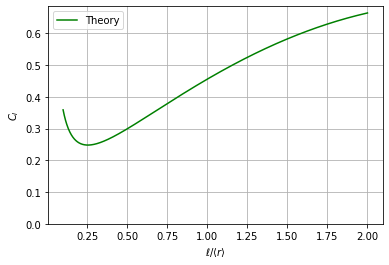

In [7]:
%matplotlib inline
fig, ax = plt.subplots()
xlabel = r"$\ell/\langle r\rangle$"

ax.plot(ell_list, Ci_theory, "-", c='green', label="Theory")
ax.set_ylabel(r"$C_I$")

ax.set_xlabel(xlabel)
ax.legend()
ax.grid()

ax.set_ylim((0,None))

plt.show()

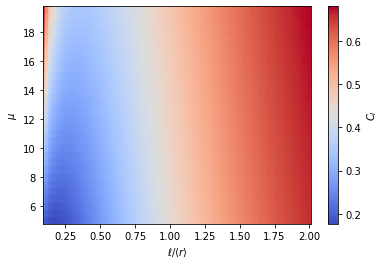

In [8]:
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots()

mu_range = np.arange(5,20,0.5)
ell_range = np.linspace(ell_min,ell_max,100)
ELL, MU = np.meshgrid(ell_range, mu_range)

CI_THEORY,_,_,_ = getCarbonIndexVectorized(ELL, eta, eps0, Q_func(MU))

# ax.plot_surface(ELL, MU, CI_THEORY, cmap='coolwarm')
im = ax.pcolormesh(ELL, MU, CI_THEORY, cmap='coolwarm', shading='auto')
ax.set_xlabel(r'$\ell/\langle r\rangle$')
ax.set_ylabel(r'$\mu$')
fig.colorbar(im, label=r'$C_I$')

plt.show()

---
- Carbon emissions for PT are constant w.r.t amount of requests, DRT emissions not on the other hand. Criterion from discriminant shows when DRT emissions $\gtrsim$ PT emissions for high ell?
    - Otherwise Unimodal would be most effective
- For given request frequency - what is a good tradeoff btw. convenience (increasing $\mu$) and emissions (decreasing $\mu$)?
---